In [ ]:
import numpy as np
from torchvision import datasets, transforms

dtype = np.float32

In [2]:
#MNIST data set
training_data_set = datasets.MNIST(
    root        = "./data/MNIST/",
    train       = True,
    transform   = transforms.ToTensor,
    download    = True
    ).data.numpy() / 255

testing_data_set = datasets.MNIST(
    root        = "./data/MNIST/",
    train       = False,
    transform   = transforms.ToTensor,
    download    = True
    ).data.numpy() / 255

training_data_set = np.asarray(training_data_set, dtype)
testing_data_set  = np.asarray(testing_data_set , dtype)

#training_data_set[training_data_set <  0.4] = 0
#training_data_set[training_data_set >= 0.4] = 1
#testing_data_set[testing_data_set   <  0.4] = 0
#testing_data_set[testing_data_set   >= 0.4] = 1

In [3]:
def random_separate(
        data_set_size   : int,
        separate_size   : int | tuple,
        seed            : int | None = None
        ):
    
    rs = np.random.RandomState(seed)
    if hasattr(separate_size, "__iter__"):
        _randIdx = rs.choice(data_set_size, sum(list(separate_size)), replace = False)
        randIdx = []
        for i in range(len(separate_size)):
            randIdx.append(_randIdx[sum(separate_size[: i]) : sum(separate_size[: i + 1])])
    else:
        randIdx = rs.choice(data_set_size, separate_size, replace = False)

    return randIdx


n_validation = 5000
n_training   = 60000 - n_validation
n_testing    = 10000

idx_training_data_set, idx_validation_data_set = random_separate(
    data_set_size = training_data_set.shape[0], 
    separate_size = (n_training, n_validation),
    seed          = 12345
    )

idx_testing_data_set = random_separate(
    data_set_size = testing_data_set.shape[0], 
    separate_size = n_testing,
    seed          = 12345
)

validation_data_set = training_data_set[idx_validation_data_set]
training_data_set   = training_data_set[idx_training_data_set]
testing_data_set    = testing_data_set[idx_testing_data_set]

training_data_set.shape, validation_data_set.shape, testing_data_set.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [4]:
from Restricted_Boltzmann_Machine.Restricted_Boltzmann_Machine import RBM
from Restricted_Boltzmann_Machine.Training import RBM_training

visible_size = 28 * 28
hidden_size  = 64
rbm = RBM(
    visible_size  = visible_size,
    hidden_size   = hidden_size,
    seed          = 743621,
    dtype         = np.float32,
    k             = 2
    )

batch_size = 1024
training = RBM_training(
    rbm                 = rbm,
    epochs              = 1000,
    training_samples    = training_data_set,
    validation_samples  = validation_data_set,
    testing_samples     = testing_data_set,
    batch_size          = batch_size,
    learning_rate       = 0.1,
    algorithm = "CD"
)


In [5]:
training.start_training(5)

5-th epoch finished. Time= 4.09e+00 s. Loss= -3.1825e+00 , Train_acc= 8.6761e-01 , Vali_acc= 8.6812e-01 , Test_acc= 8.7044e-01 , Free_en= -2.4834e+01
10-th epoch finished. Time= 3.79e+00 s. Loss= -3.6723e+00 , Train_acc= 8.8312e-01 , Vali_acc= 8.8352e-01 , Test_acc= 8.8456e-01 , Free_en= -4.9097e+01
15-th epoch finished. Time= 3.87e+00 s. Loss= -3.9275e+00 , Train_acc= 8.9053e-01 , Vali_acc= 8.9088e-01 , Test_acc= 8.9182e-01 , Free_en= -6.3125e+01
20-th epoch finished. Time= 3.84e+00 s. Loss= -4.0755e+00 , Train_acc= 8.9510e-01 , Vali_acc= 8.9545e-01 , Test_acc= 8.9614e-01 , Free_en= -7.2150e+01
25-th epoch finished. Time= 3.84e+00 s. Loss= -4.2174e+00 , Train_acc= 8.9840e-01 , Vali_acc= 8.9878e-01 , Test_acc= 8.9925e-01 , Free_en= -7.9212e+01
30-th epoch finished. Time= 3.86e+00 s. Loss= -4.2936e+00 , Train_acc= 9.0088e-01 , Vali_acc= 9.0110e-01 , Test_acc= 9.0167e-01 , Free_en= -8.4575e+01
35-th epoch finished. Time= 3.96e+00 s. Loss= -4.3670e+00 , Train_acc= 9.0277e-01 , Vali_acc= 9

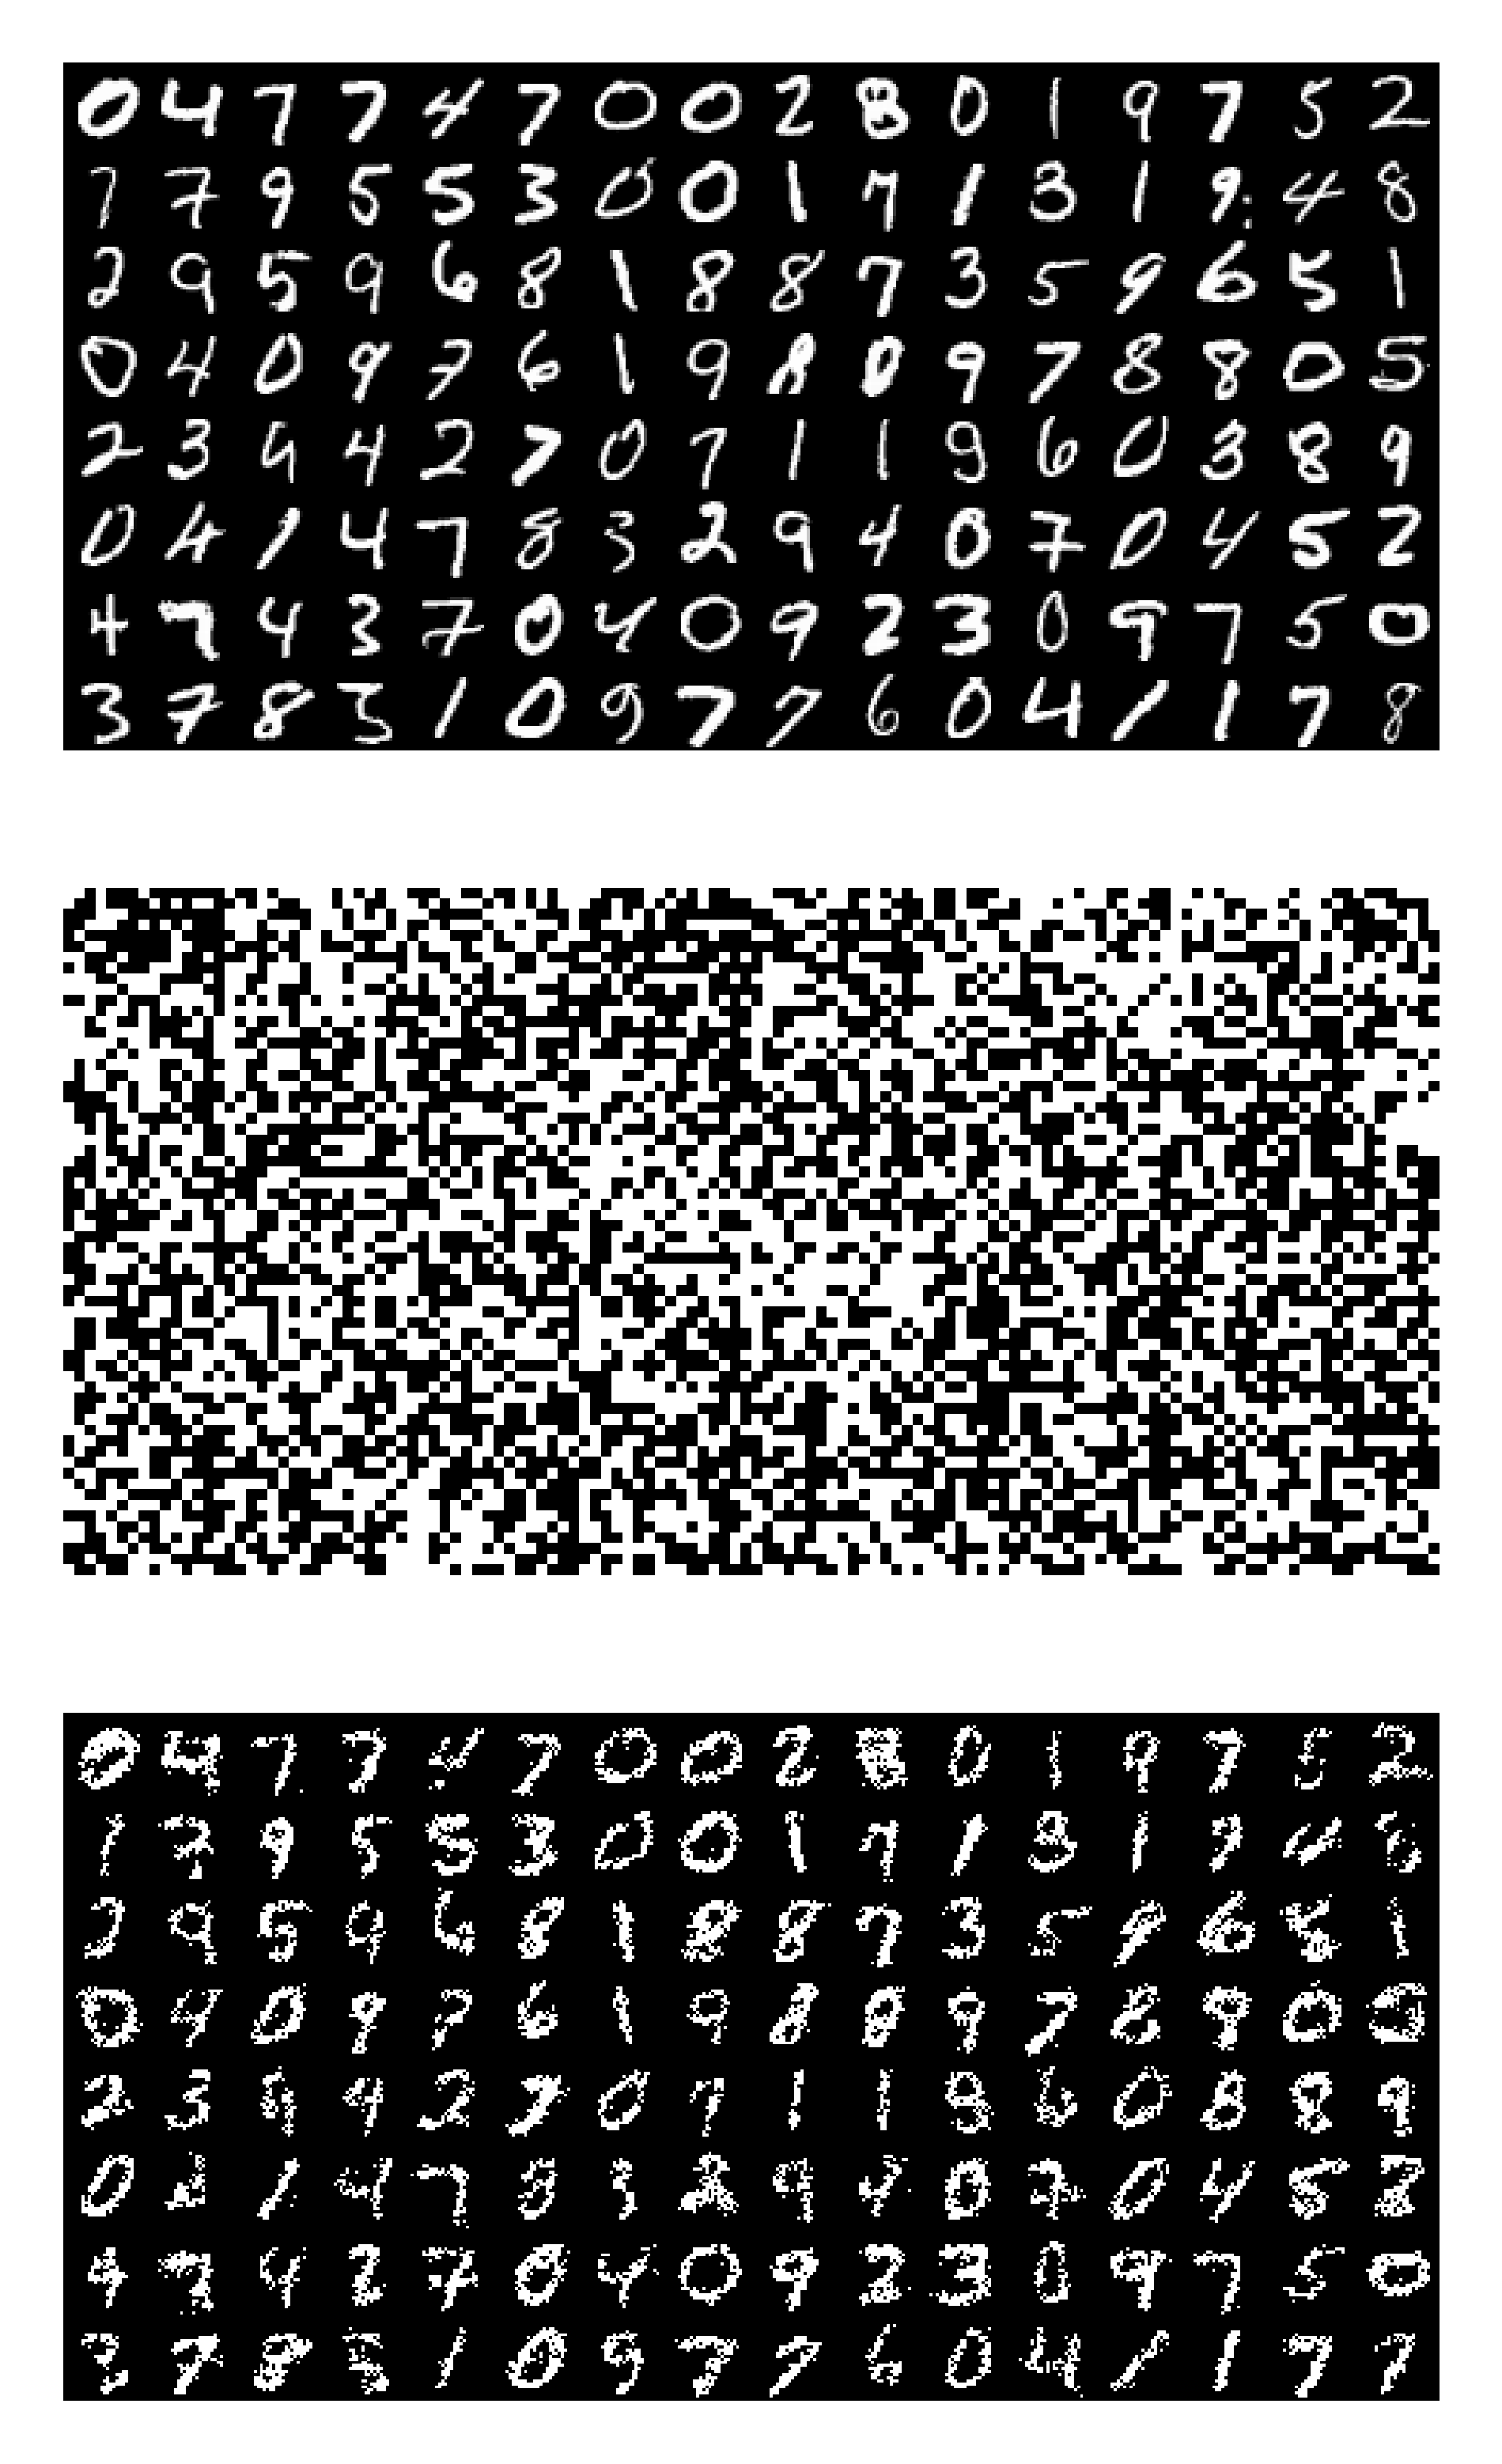

In [11]:
figure_shape = (28, 28)
verify_shape = (8, 16)
n_figs = verify_shape[0] * verify_shape[1]

reconstruct = np.zeros(shape = (n_figs, 28*28), dtype = dtype)
h_model     = np.zeros(shape = (n_figs, 8*8), dtype = dtype)
testing = testing_data_set[: n_figs].reshape((n_figs, 28*28))

for i_batch in range(n_figs // min(n_figs, batch_size)):
    verify_slice = slice(i_batch * batch_size, (i_batch + 1) * batch_size)
    reconstruct[verify_slice], h_model[verify_slice], _, _, _, _ = rbm.forward(testing[verify_slice])

testing     = testing.reshape((*verify_shape, figure_shape[0], figure_shape[1]))
reconstruct = reconstruct.reshape((*verify_shape, figure_shape[0], figure_shape[1]))
h_model     = h_model.reshape((*verify_shape, 8, 8))

import matplotlib.pyplot as plt
#(x,y,i,j) -> (x,i,y,j)
#(0,1,2,3) -> (0,2,1,3)
testing = testing.transpose((0,2,1,3))
testing = testing.reshape(figure_shape[0] * verify_shape[0], figure_shape[1] * verify_shape[1])

reconstruct = reconstruct.transpose((0,2,1,3))
reconstruct = reconstruct.reshape(figure_shape[0] * verify_shape[0], figure_shape[1] * verify_shape[1])

h_model = h_model.transpose((0,2,1,3))
h_model = h_model.reshape(8 * verify_shape[0], 8 * verify_shape[1])

fig = plt.figure(dpi = 800)
ax1 = fig.add_subplot(311)
ax1.set_axis_off()

ax2 = fig.add_subplot(312)
ax2.set_axis_off()

ax3 = fig.add_subplot(313)
ax3.set_axis_off()

try:
    #Cupy
    ax1.imshow(testing.get(), cmap="gray")
    ax2.imshow(h_model.get(), cmap="gray")
    ax3.imshow(reconstruct.get(), cmap="gray")
except:
    #Numpy
    ax1.imshow(testing, cmap="gray")
    ax2.imshow(h_model, cmap="gray")
    ax3.imshow(reconstruct, cmap="gray")

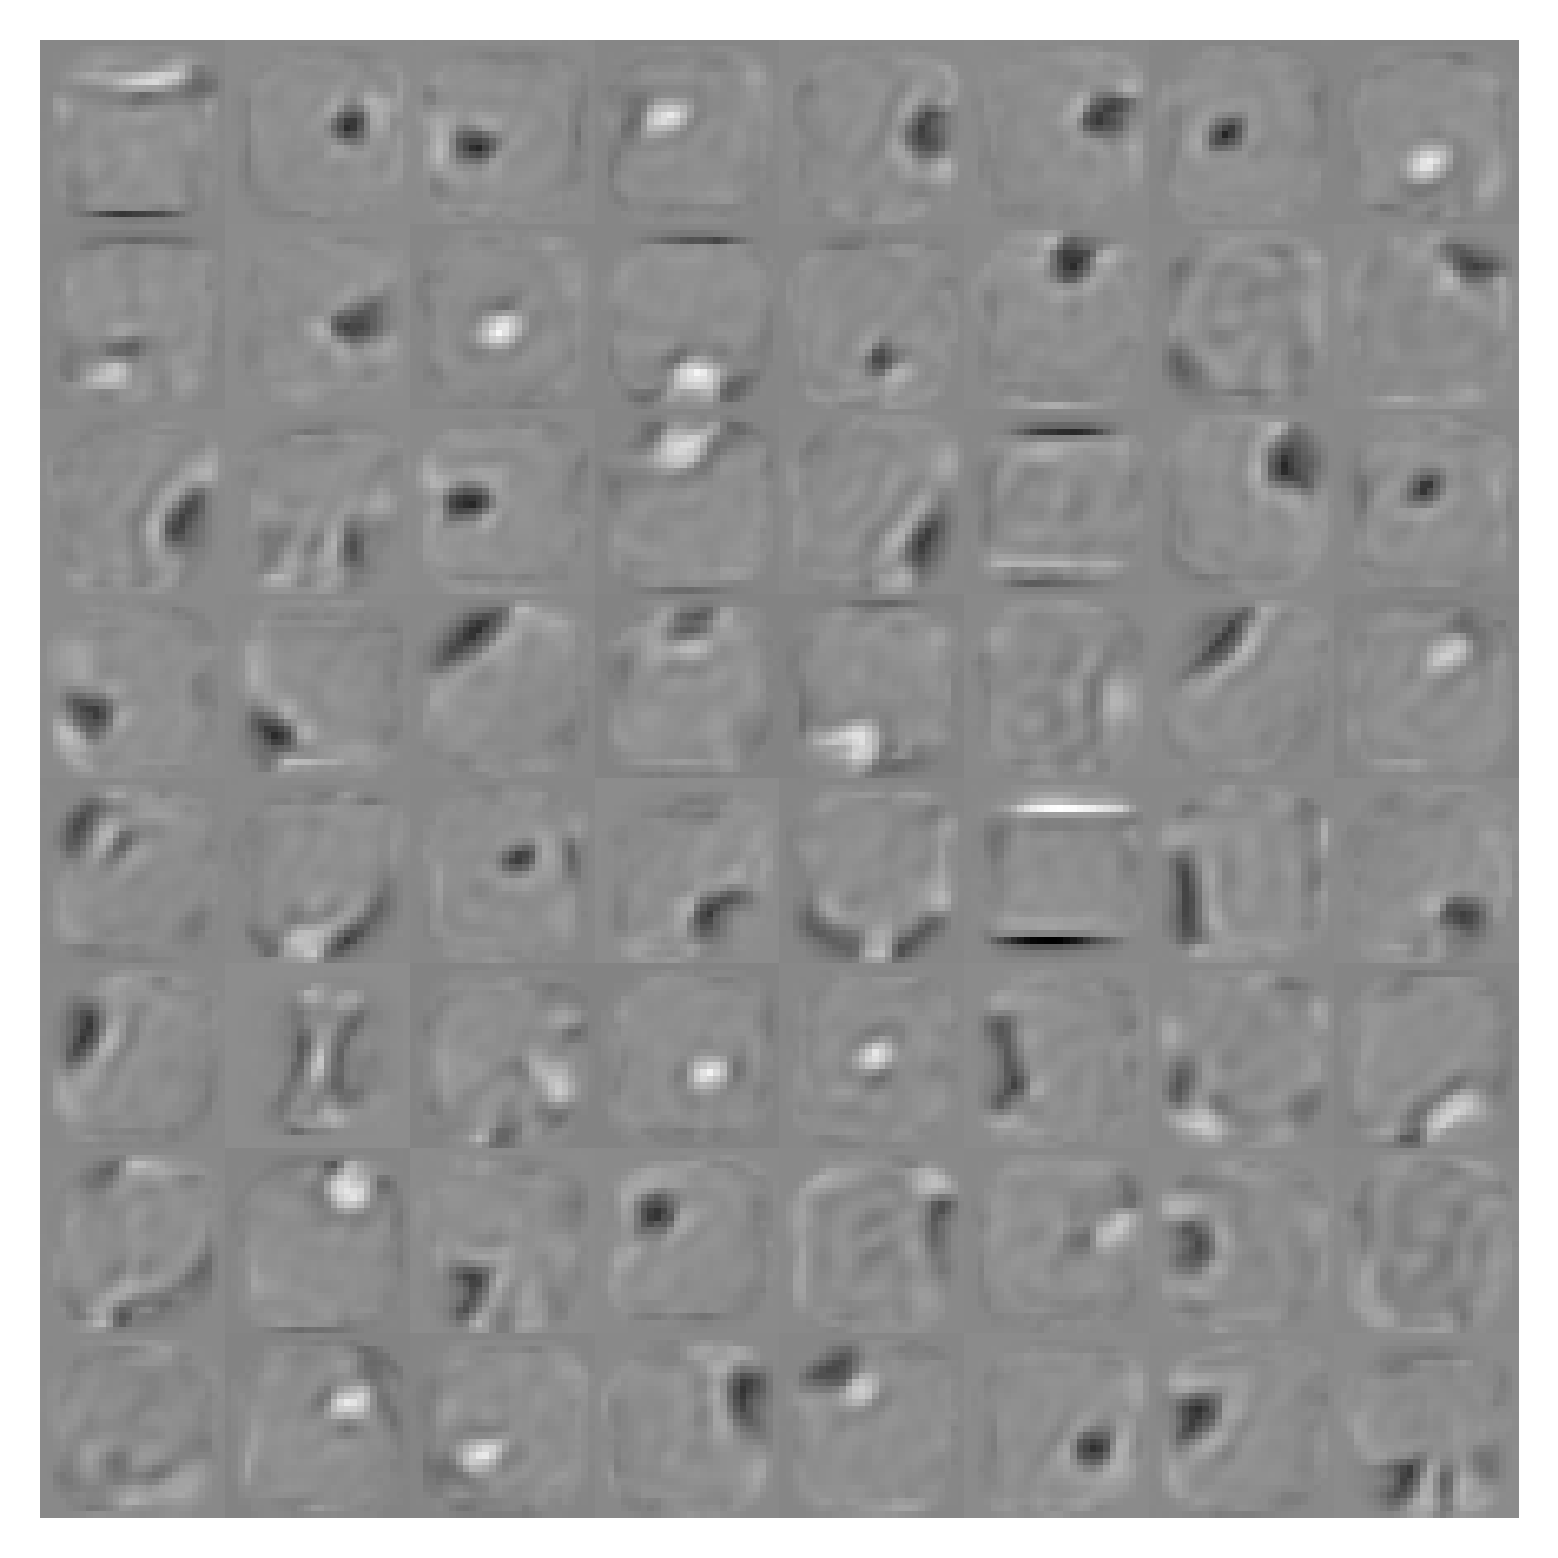

In [12]:
import matplotlib.pyplot as plt

#(i,j,x,y) -> (x,i,y,j)
#(0,1,2,3) -> (2,0,3,1)
hidden_shape = (8, 8)
W = rbm.Weight.reshape(28, 28, hidden_shape[0], hidden_shape[1])
W = np.transpose(W, (2,0,3,1)).reshape(figure_shape[0] * hidden_shape[0], figure_shape[1] * hidden_shape[1])

fig = plt.figure(dpi = 400)
ax = fig.add_subplot(111)
ax.set_axis_off()

try:
    ax.imshow(W.get(), cmap="gray")
except:
    ax.imshow(W, cmap="gray")
